## Diversity optimization

In [1]:
# potential issues
# 1) seems that the dist has always the most impact > change the parameter lambda, also neg values of the functions but that should not be a problem (?)
# 3) structure of the DT and influence of the choice of norm
# 4) no solution CE > add a check, also change confidence eps

In [2]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

# imported packages
from lineartree import LinearTreeClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

### Example on continuous only attributes

In [4]:
continuous_only = False

### Read dataframe

In [5]:
# read dataset
df = pd.read_csv('../data/adult/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# simplify dataframe
del df['marital-status']
del df['native-country']
del df['occupation']
del df['relationship']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&()]", "", regex=True)
df = df.replace('[-&()]', '', regex=True)
# missing values imputation with mode (needed for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           48842 non-null  int64 
 1   workclass     48842 non-null  object
 2   education     48842 non-null  object
 3   race          48842 non-null  object
 4   sex           48842 non-null  object
 5   capitalgain   48842 non-null  int64 
 6   capitalloss   48842 non-null  int64 
 7   hoursperweek  48842 non-null  int64 
 8   class         48842 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.4+ MB


In [6]:
df

,age,workclass,education,race,sex,capitalgain,capitalloss,hoursperweek,class
0,39,Stategov,Bachelors,White,Male,2174,0,40,<=50K
1,50,Selfempnotinc,Bachelors,White,Male,0,0,13,<=50K
2,38,Private,HSgrad,White,Male,0,0,40,<=50K
3,53,Private,11th,Black,Male,0,0,40,<=50K
4,28,Private,Bachelors,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,White,Female,0,0,36,<=50K
48838,64,Private,HSgrad,Black,Male,0,0,40,<=50K
48839,38,Private,Bachelors,White,Male,0,0,50,<=50K
48840,44,Private,Bachelors,AsianPacIslander,Male,5455,0,40,<=50K


In [7]:
df = df.replace(['1st4th', '5th6th', '7th8th', '9th', '10th', '11th', '12th'], ['Firstfourth', 'Fifthsixth', 'Seventheighth', 'Nineth','Tenth', 'Eleventh', 'Twelvths'])

In [8]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = [] if continuous_only else ['race', 'sex', 'workclass']
ordinal_atts = [] if continuous_only else ['education']
continuous_atts = ['age', 'capitalgain', 'hoursperweek'] if continuous_only else ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts

In [9]:
decode_ = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}

In [10]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'Firstfourth', 3:'Fifthsixth', 4:'Seventheighth', 5:'Nineth', 6:'Tenth', 7:'Eleventh',
        8:'Twelvths', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
prefix_sep = "_" # separator for one-hot encoding
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep=prefix_sep)
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,race_AsianPacIslander,race_Black,race_Other,race_White,sex_Female,sex_Male,capitalgain,capitalloss,hoursperweek,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,1,0,1,2174,0,40,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,1,0,1,0,0,13,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,1,0,1,0,0,40,0
3,53,0,0,0,1,0,0,0,0,7,...,0,1,0,0,0,1,0,0,40,0
4,28,0,0,0,1,0,0,0,0,13,...,0,1,0,0,1,0,0,0,40,0


In [11]:
# encode-decoding dictionaries
df_code.encode, df_code.decode

({'education': {'Preschool': 1,
   'Firstfourth': 2,
   'Fifthsixth': 3,
   'Seventheighth': 4,
   'Nineth': 5,
   'Tenth': 6,
   'Eleventh': 7,
   'Twelvths': 8,
   'HSgrad': 9,
   'Somecollege': 10,
   'Assocvoc': 11,
   'Assocacdm': 12,
   'Bachelors': 13,
   'Masters': 14,
   'Profschool': 15,
   'Doctorate': 16},
  'class': {'<=50K': 0, '>50K': 1},
  'age': (17, 90),
  'workclass': {'Federalgov': 0,
   'Localgov': 1,
   'Neverworked': 2,
   'Private': 3,
   'Selfempinc': 4,
   'Selfempnotinc': 5,
   'Stategov': 6,
   'Withoutpay': 7},
  'capitalgain': (0, 99999),
  'sex': {'Female': 0, 'Male': 1},
  'race': {'AmerIndianEskimo': 0,
   'AsianPacIslander': 1,
   'Black': 2,
   'Other': 3,
   'White': 4},
  'capitalloss': (0, 4356),
  'hoursperweek': (1, 99)},
 {'education': {1: 'Preschool',
   2: 'Firstfourth',
   3: 'Fifthsixth',
   4: 'Seventheighth',
   5: 'Nineth',
   6: 'Tenth',
   7: 'Eleventh',
   8: 'Twelvths',
   9: 'HSgrad',
   10: 'Somecollege',
   11: 'Assocvoc',
   12: '

In [12]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# split predictive and target
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
#X1, _, y1, _ = train_test_split(X, y, test_size=0.3, random_state=42)
#X2, _, y2, _ = train_test_split(X, y, test_size=0.3, random_state=24)
# retain test sets
X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)
#X2, XT2, y2, yt2 = train_test_split(X, y, test_size=0.3, random_state=24)
# train a decision tree
clf1 = DecisionTreeClassifier(max_depth=4)
clf1.fit(X1, y1)
#clf2 = DecisionTreeClassifier(max_depth=3)
#clf2.fit(X2, y2)

DecisionTreeClassifier(max_depth=4)

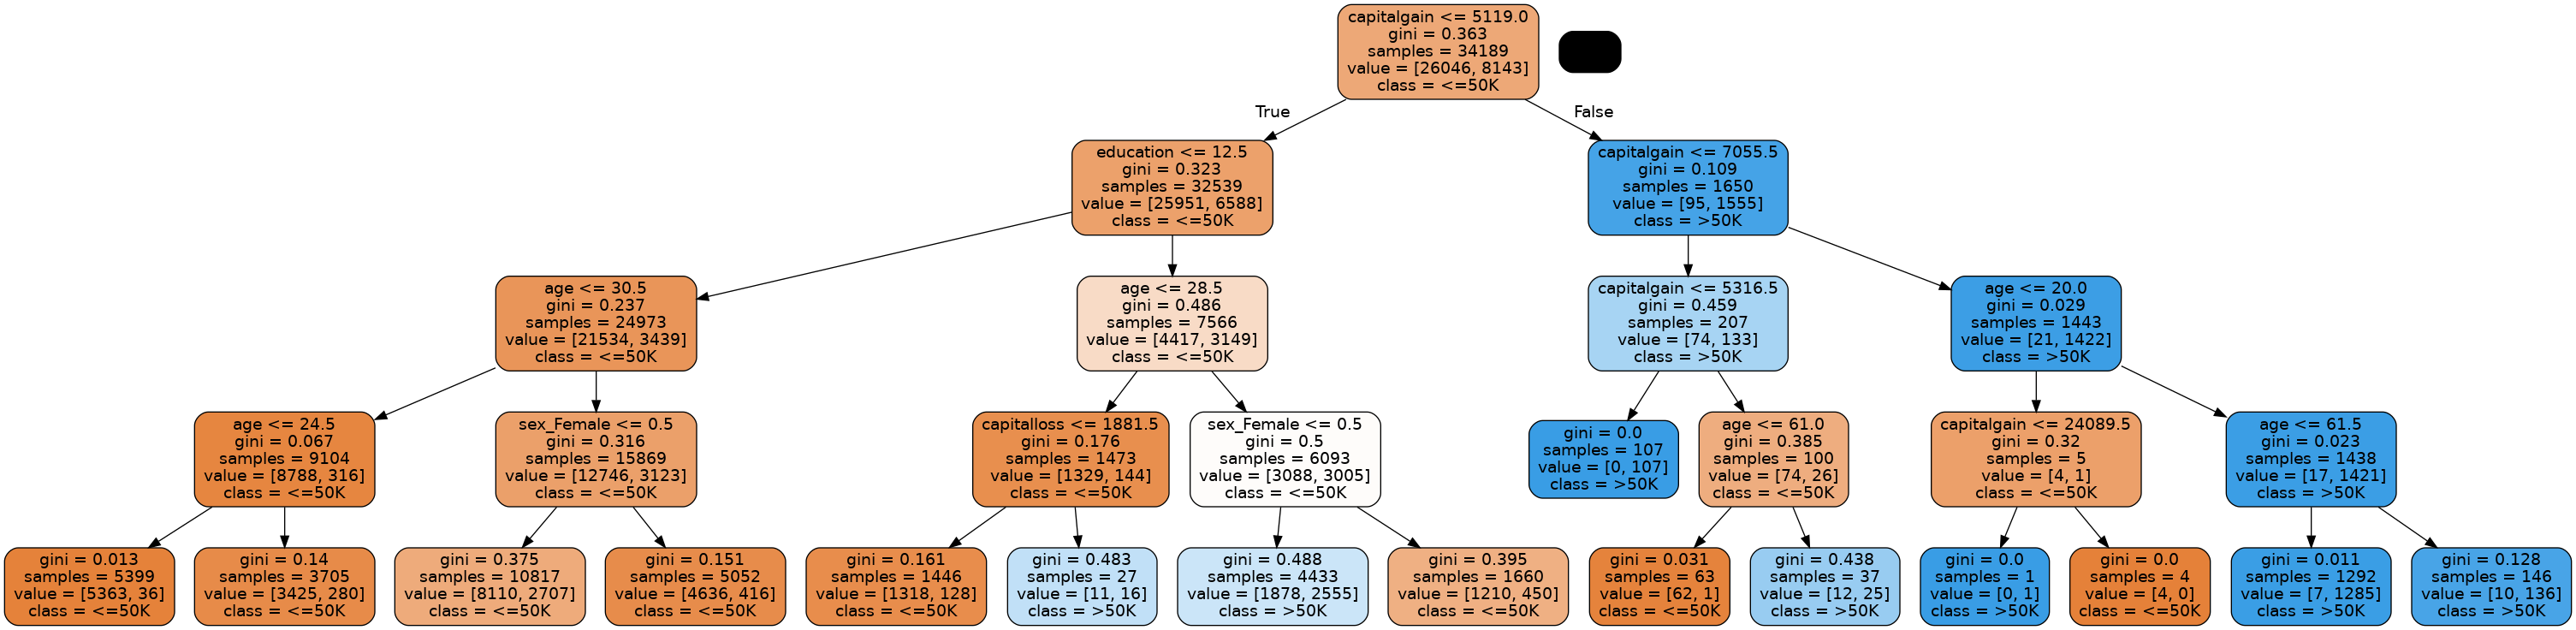

In [13]:
# visualize the decision tree
dot_data = tree.export_graphviz(clf1, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Experiment

In [14]:
# Model2CLP
r = reasonx.ReasonX(pred_atts, target, df_code, verbose=0)
r.model(clf1)

In [15]:
# number of instances
n_instances = 58
# number of CEs to select
setsize = 3
# weight of the diversity term
alpha = 1

# 22 and 23 or only 23
skip = [20, 22, 23, 26, 31, 34, 37, 48]

# collect function values of the individual parts/total opt function
collect_dist = []
collect_div = []
collect_total = []

# collect the same values again to compare to an optimization by distance only
collect_dist_ = []
collect_div_ = []
collect_total_ = []

for switch in ["total", "distance"]:
    # first iteration diversity opt (both terms minimum, safe all results)
    # second iteration distance opt (first term minimium, safe all results incl value of full function)
    # separate loop nedded because the div term changes as soon as more than 1 CE is selected

    for p in range(n_instances):
        # exclude items that cause an error
        if p in skip:
            continue
        else:
            print("for loop", p)
            
            # intialize instances
            r.instance('F0', features=XT1.iloc[p:p+1], label=yt1.iloc[p])
            r.instance('CE0', label=1-yt1.iloc[p])

            print("LABEL", clf1.predict(XT1.iloc[p:p+1]))

            # generate all possible CEs
            # setting eps
            constraints, n_ce, b, c, d, e = r.solveopt(minimize='l1norm(F0, CE0)', return_results = 1, evaluation=1, eps = 0.01)
            
            print("Number of CEs ", n_ce)

            # check whether there is a solution
            if n_ce == 0:
                continue
            else:
                
                # STEP 1: select the first CE based on minimal distance

                # index and constaints ("data") of the selected CE
                ce_index_min_dist = b.index(min(b))
                ce_constraints_min_dist = constraints[ce_index_min_dist][1]

                d0 = min(b)
                #lambda_ = 1 / (2 * d0)
                lambda_= 1/2

                # list of indices of all CEs that are selected in the process of selecting based on div evaluation
                index_list = [ce_index_min_dist]

                # STEP 2: enforce CE

                # enforce contraints of the selected CE
                r.constraint(ce_constraints_min_dist)

                # STEP 3: compute function values for two, three,... CEs

                for j in range(setsize - 1):
                    # initialize new CE (rename because the CE has to be different), only additional ones thus starting at "1"
                    new_ce_name = "CE" + str(j + 1)
                    r.instance(new_ce_name, label=1-yt1.iloc[p])
                    
                    # list of all CEs as string, to be extended during each iteration
                    # ce_names = [ce names]
                    base = j + 2
                    ce_names = "["
                    for k in range(base):
                        ce_names = ce_names + "CE" + str(k) + ", "
                    ce_names = ce_names[:-2] + "]"

                    # total opt function
                    function_values = []
                    # index of CE
                    ind = []
                    # individual parts opt function
                    values_dist = []
                    values_div = []

                    # over all previously generated CEs
                    for i in range(int(n_ce)):
                        # skip CEs that are already chosen
                        if i in index_list:
                            continue
                        else:
                            print("CONTRASTIVE INSTANCE NO", i)
                            # replace name of CE
                            constraints_ = constraints[i][1].replace("CE0", new_ce_name)
                            r.constraint(constraints_)
                            # compute function values
                            # term 1 (distance)
                            term1 = "l1norm(F0, " + ce_names + ")"
                            function_1 = r.solveopt(minimize=term1, evaluation=None, diversity=1, eps = 0.01)
                            print(term1, function_1)
                            values_dist.append(function_1[0])
                            # term 2 (diversity)
                            function_2 = 0
                            for l in range(base):
                                term2 = "l1norm(CE" + str(l) + ", " + ce_names + ")"
                                function_2_update = r.solveopt(minimize=term2, evaluation=None, diversity=1, eps = 0.01)
                                function_2 = function_2 + function_2_update[0]
                            values_div.append(function_2)

                            r.retract(constraints_)
                            
                            # total opt function
                            function_values.append((((float(lambda_/base) * function_1[0]) - (float(alpha /(base * base)) * function_2))))
                            # index of CE
                            ind.append(i)
                            print("VALUES", function_1[0], function_2, (((float(lambda_/base) * function_1[0]) - (float(alpha /(base * base)) * function_2))))

                    if switch == "total":
                        # index of CE with minimum value
                        function_values_index = function_values.index(min(function_values))
                        # constraints of the same CE
                        ce_constraints_min_dist_ = constraints[ind[function_values_index]][1]

                        #print("function values", function_values)
                        #print("index in CE in the original array", ind[function_values_index])
                        #print("index of CE with minimal value", function_values_index)
                        #print("constraints", ce_constraints_min_dist)
                        #print("value function total", function_values[function_values_index])

                        # add original index (CE in the list of admissible sets) to index_list to avoid re-computing over it
                        # this is also the results: index position of the subset of CEs
                        index_list.append(ind[function_values_index])

                        collect_dist.append(values_dist)
                        collect_div.append(values_div)
                        collect_total.append(function_values)
                    
                    # optimize based only on the first term, other index/constraints
                    if switch == "distance":
                        function_values_index = values_dist.index(min(values_dist))
                        ce_constraints_min_dist_ = constraints[ind[function_values_index]][1]
                        index_list.append(ind[function_values_index])

                        collect_dist_.append(values_dist)
                        collect_div_.append(values_div)
                        collect_total_.append(function_values)

                    # add the new CE to the store
                    r.constraint(ce_constraints_min_dist_.replace("CE0", new_ce_name))
        
            # reset the model
            r.reset(keep_model=True)

for loop 0
LABEL [0]
Number of CEs  7.0
CONTRASTIVE INSTANCE NO 0
l1norm(F0, [CE0, CE1]) [0.749792540280775]
VALUES 0.749792540280775 1.4995850805615503 -0.1874481350701938
CONTRASTIVE INSTANCE NO 1
l1norm(F0, [CE0, CE1]) [0.4618298813125119]
VALUES 0.4618298813125119 0.9236597626250238 -0.11545747032812798
CONTRASTIVE INSTANCE NO 3
l1norm(F0, [CE0, CE1]) [0.6935343257542167]
VALUES 0.6935343257542167 1.1823062038839567 -0.122192969532435
CONTRASTIVE INSTANCE NO 4
l1norm(F0, [CE0, CE1]) [0.1217464174641747]
VALUES 0.1217464174641747 0.038730387303872675 0.020754007540075503
CONTRASTIVE INSTANCE NO 5
l1norm(F0, [CE0, CE1]) [0.14928066403951734]
VALUES 0.14928066403951734 0.09379888045455798 0.013870445896239841
CONTRASTIVE INSTANCE NO 6
l1norm(F0, [CE0, CE1]) [0.7177738147244489]
VALUES 0.7177738147244489 1.2307851818244209 -0.128252841774993
CONTRASTIVE INSTANCE NO 1
l1norm(F0, [CE0, CE1, CE2]) [1.160431809687168]
VALUES 1.160431809687168 3.575060572082005 -0.20382365083902812
CONTRAST

In [16]:
print(collect_total)
print(collect_total_)

[[-0.1874481350701938, -0.11545747032812798, -0.122192969532435, 0.020754007540075503, 0.013870445896239841, -0.128252841774993], [-0.20382365083902812, -0.36395313196641155, -0.20512315744139994, -0.21277155926788405, -0.37068632334703167], [-0.20411480173686047, -0.3855487945290413, -0.12561762706668153, 0.020754007540075503, 0.010445788361993287, -0.13167749930923958], [-0.4928140110622649, -0.5177940473468658, -0.4252350012845637, -0.4183628551658424, -0.5245272387274861], [-0.1874481350701938, -0.09148486758840196, -0.0982203667927089, 0.003630719868842683, 0.020754007540075503, -0.10428023903526698], [-0.1771874255726658, -0.3373169067000494, -0.22414903263165867, -0.20512315744139994, -0.3440500980806694], [-0.17078146840352706, -0.34194148859296813, -0.1153436544639419, 0.020754007540075503, 0.020719760964733006, -0.12140352670649987], [-0.46658367113329496, -0.47619080026416705, -0.3767824391333715, -0.3767596080831431, -0.48292399164478705], [-0.2508042994537553, -0.079464319

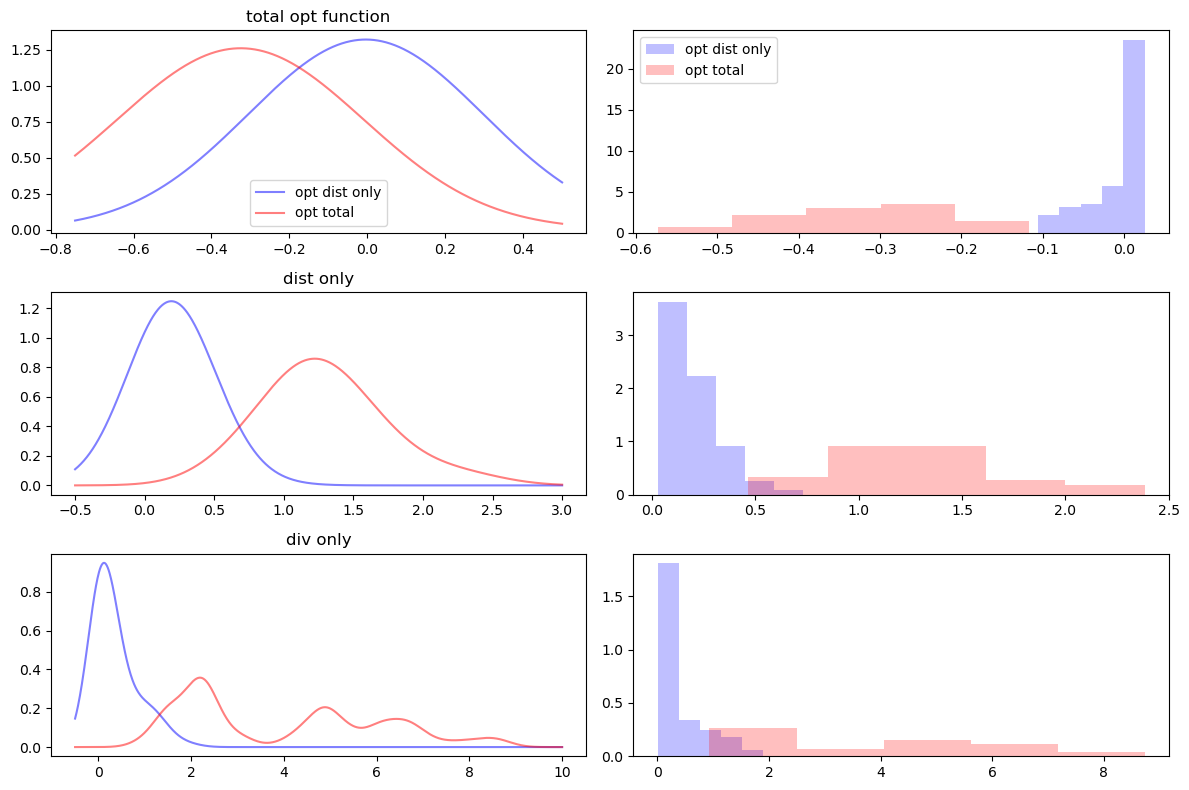

In [17]:
# when I select the 2nd CE, this can be done by dist or div, I have original value
# when I select the 3rd CE, the prev 2 selected ones are by div, so the function values are a bit misleading > updated prev code

import matplotlib.pyplot as plt
plt.figure(figsize= (12, 8))

opt_function_dist_complete = []
opt_function_complete_complete = []
opt_function_dist_dist = []
opt_function_dist_div = []
opt_function_complete_dist = []
opt_function_complete_div = []

for i in range(len(collect_dist)):
    # total opt function
    collect_dist_instance = collect_dist[i]
    collect_total_instance = collect_total[i]
    collect_div_instance = collect_div[i]
    # distance
    collect_dist_instance_ = collect_dist_[i]
    collect_total_instance_ = collect_total_[i]
    collect_div_instance_ = collect_div_[i]
    # first iteration only
    #if len(collect_total__) == 6:
    # min by distance only, index
    dist_only_index = collect_dist_instance_.index(min(collect_dist_instance_))
    # values
    opt_function_dist_complete.append(collect_total_instance_[dist_only_index])
    opt_function_dist_dist.append(min(collect_dist_instance_))
    opt_function_dist_div.append(collect_div_instance_[dist_only_index])
    # min by total distance, index
    total_index = collect_total_instance.index(min(collect_total_instance))
    # values
    opt_function_complete_complete.append(min(collect_total_instance))
    opt_function_complete_dist.append(collect_dist_instance[total_index])
    opt_function_complete_div.append(collect_div_instance[total_index])

# plot density function
x1 = np.linspace(-0.75, 0.5, 1000)
x2 = np.linspace(-0.5, 3, 1000)
x3 = np.linspace(-0.5, 10, 1000)

# Calculate the density using a Gaussian kernel
def gaussian_kernel(x, data, bandwidth):
    return np.sum(np.exp(-0.5 * ((x[:, None] - data) / bandwidth) ** 2), axis=1) / (data.size * bandwidth * np.sqrt(2 * np.pi))

# Set the bandwidth
bandwidth = 0.3

# Calculate the density
density_dist_complete = gaussian_kernel(x1, np.array(opt_function_dist_complete), bandwidth)
density_complete_complete = gaussian_kernel(x1, np.array(opt_function_complete_complete), bandwidth)
density_dist_dist = gaussian_kernel(x2, np.array(opt_function_dist_dist), bandwidth)
density_complete_dist = gaussian_kernel(x2, np.array(opt_function_complete_dist), bandwidth)
density_dist_div = gaussian_kernel(x3, np.array(opt_function_dist_div), bandwidth)
density_complete_div = gaussian_kernel(x3, np.array(opt_function_complete_div), bandwidth)

#counts, bin_edges = np.histogram(opt_function_dist_complete, bins=10, density=True)
#plt.hist(opt_function_dist_complete, bin_edges, color='blue', alpha = 0.7)

# Create the plot
plt.subplot(3, 2, 1)
plt.title("total opt function")
plt.plot(x1, density_dist_complete, color='blue', alpha=0.5, label = "opt dist only")
plt.plot(x1, density_complete_complete, color='red', alpha=0.5, label = "opt total")
plt.legend()
plt.subplot(3, 2, 2)
plt.hist(opt_function_dist_complete, bins = 5, color='blue', alpha = 0.25, density=True, label = "opt dist only")
plt.hist(opt_function_complete_complete, bins = 5, color='red', alpha = 0.25, density=True, label = "opt total")
plt.legend()
plt.subplot(3, 2, 3)
plt.title("dist only")
plt.plot(x2, density_dist_dist, color='blue', alpha=0.5)
plt.plot(x2, density_complete_dist, color='red', alpha=0.5)
plt.subplot(3, 2, 4)
plt.hist(opt_function_dist_dist, bins = 5, color='blue', alpha = 0.25, density=True)
plt.hist(opt_function_complete_dist, bins = 5, color='red', alpha = 0.25, density=True)
plt.subplot(3, 2, 5)
plt.title("div only")
plt.plot(x3, density_dist_div, color='blue', alpha=0.5)
plt.plot(x3, density_complete_div, color='red', alpha=0.5)
plt.subplot(3, 2, 6)
plt.hist(opt_function_dist_div, bins = 5, color='blue', alpha = 0.25, density=True)
plt.hist(opt_function_complete_div, bins = 5, color='red', alpha = 0.25, density=True)
plt.tight_layout()
plt.show()

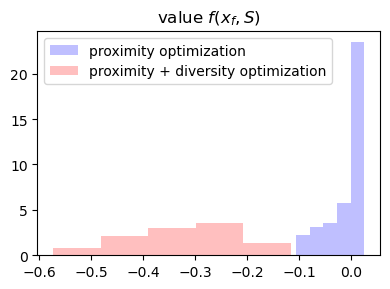

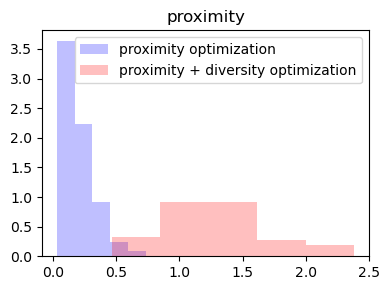

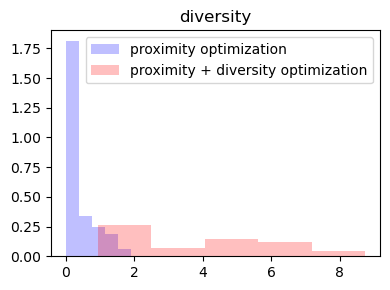

In [32]:
# histograms only
# naming as in the paper (proximity and diversity)

import matplotlib.pyplot as plt

# Calculate the density
density_dist_complete = gaussian_kernel(x1, np.array(opt_function_dist_complete), bandwidth)
density_complete_complete = gaussian_kernel(x1, np.array(opt_function_complete_complete), bandwidth)
density_dist_dist = gaussian_kernel(x2, np.array(opt_function_dist_dist), bandwidth)
density_complete_dist = gaussian_kernel(x2, np.array(opt_function_complete_dist), bandwidth)
density_dist_div = gaussian_kernel(x3, np.array(opt_function_dist_div), bandwidth)
density_complete_div = gaussian_kernel(x3, np.array(opt_function_complete_div), bandwidth)

#counts, bin_edges = np.histogram(opt_function_dist_complete, bins=10, density=True)
#plt.hist(opt_function_dist_complete, bin_edges, color='blue', alpha = 0.7)

# Create the plot
for p in range(3):
    plt.figure(figsize= (4, 3))
    if p == 0:
        plt.title("value $f(x_f,S)$")
        plt.hist(opt_function_dist_complete, bins = 5, color='blue', alpha = 0.25, density=True, label = "proximity optimization")
        plt.hist(opt_function_complete_complete, bins = 5, color='red', alpha = 0.25, density=True, label = "proximity + diversity optimization")
    if p == 1:
        plt.title("proximity")
        plt.hist(opt_function_dist_dist, bins = 5, color='blue', alpha = 0.25, density=True, label = "proximity optimization")
        plt.hist(opt_function_complete_dist, bins = 5, color='red', alpha = 0.25, density=True, label = "proximity + diversity optimization")
    if p == 2:
        plt.title("diversity")
        plt.hist(opt_function_dist_div, bins = 5, color='blue', alpha = 0.25, density=True, label = "proximity optimization")
        plt.hist(opt_function_complete_div, bins = 5, color='red', alpha = 0.25, density=True, label = "proximity + diversity optimization")
    plt.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig('histogram_' + str(p) + '.pdf')

<Figure size 400x300 with 0 Axes>

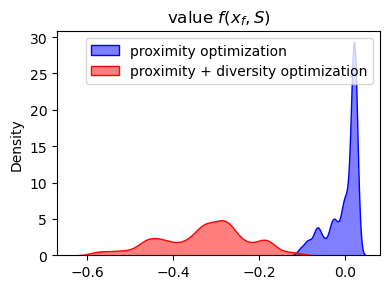

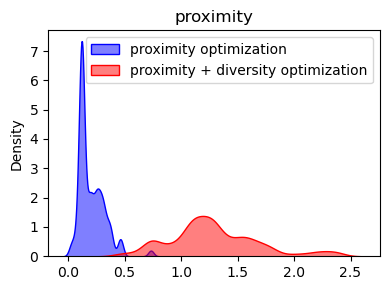

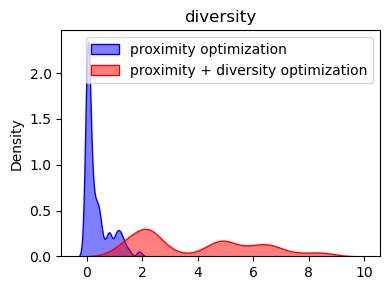

In [33]:
# density estimation only 

import seaborn as sn
plt.figure(figsize= (4, 3))

for q in range(3):
    plt.figure(figsize= (4, 3))
    if q == 0:
        plt.title("value $f(x_f,S)$")
        #plt.hist(opt_function_dist_complete, bins = 5, color='blue', alpha = 0.25, density=True, label = "opt dist only")
        #plt.hist(opt_function_complete_complete, bins = 5, color='red', alpha = 0.25, density=True, label = "opt total")
        sns.kdeplot(opt_function_dist_complete, bw_adjust=0.5, common_norm=True, fill=True, color='blue', alpha=0.5, label = "proximity optimization")
        sns.kdeplot(opt_function_complete_complete, bw_adjust=0.5, common_norm=True, fill=True, color='red', alpha=0.5, label = "proximity + diversity optimization")
        plt.legend()
    if q == 1:
        plt.title("proximity")
        #plt.hist(opt_function_dist_dist, bins = 5, color='blue', alpha = 0.25, density=True)
        #plt.hist(opt_function_complete_dist, bins = 5, color='red', alpha = 0.25, density=True)
        sns.kdeplot(opt_function_dist_dist, bw_adjust=0.5, fill=True, color='blue', alpha=0.5, label = "proximity optimization")
        sns.kdeplot(opt_function_complete_dist, bw_adjust=0.5, fill=True, color='red', alpha=0.5, label = "proximity + diversity optimization")
        plt.legend()
    if q == 2:
        plt.title("diversity")
        #plt.hist(opt_function_dist_div, bins = 5, color='blue', alpha = 0.25, density=True)
        #plt.hist(opt_function_complete_div, bins = 5, color='red', alpha = 0.25, density=True)
        sns.kdeplot(opt_function_dist_div, bw_adjust=0.5, fill=True, color='blue', alpha=0.5, label = "proximity optimization")
        sns.kdeplot(opt_function_complete_div, bw_adjust=0.5, fill=True, color='red', alpha=0.5, label = "proximity + diversity optimization")
        plt.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig('density_' + str(q) + '.pdf')

In [20]:
# kolmogorov smirnov two sided to test whether samples come from different distributions
# from the documentation:
# two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

VALUES1 = opt_function_dist_complete
VALUES2 = opt_function_complete_complete

import scipy
print(scipy.stats.ks_2samp(np.array(VALUES1), np.array(VALUES2)))

KstestResult(statistic=1.0, pvalue=5.499537172159289e-51)


In [21]:
with open('collect_total.txt', 'w') as file:
    for item in collect_total:
        file.write(f"{item}\n")

with open('collect_total_.txt', 'w') as file:
    for item in collect_total_:
        file.write(f"{item}\n")

with open('collect_dist.txt', 'w') as file:
    for item in collect_dist:
        file.write(f"{item}\n")

with open('collect_dist_.txt', 'w') as file:
    for item in collect_dist_:
        file.write(f"{item}\n")

with open('collect_div.txt', 'w') as file:
    for item in collect_div:
        file.write(f"{item}\n")

with open('collect_div_.txt', 'w') as file:
    for item in collect_div_:
        file.write(f"{item}\n")

In [25]:
# len full list 85
# length of internal list depends on number of CF
print(len(collect_total))

86
